## Equal Weights 

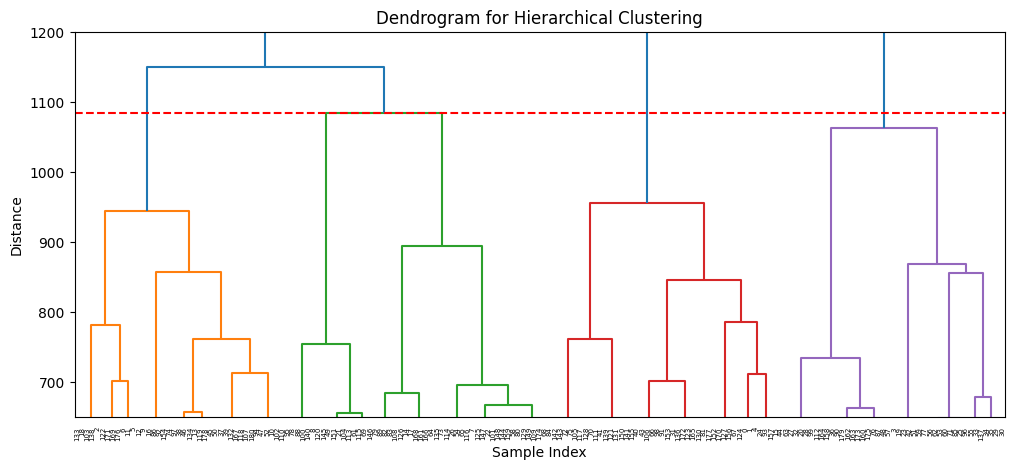

Number of crossovers for READY-TO-WEAR: 10


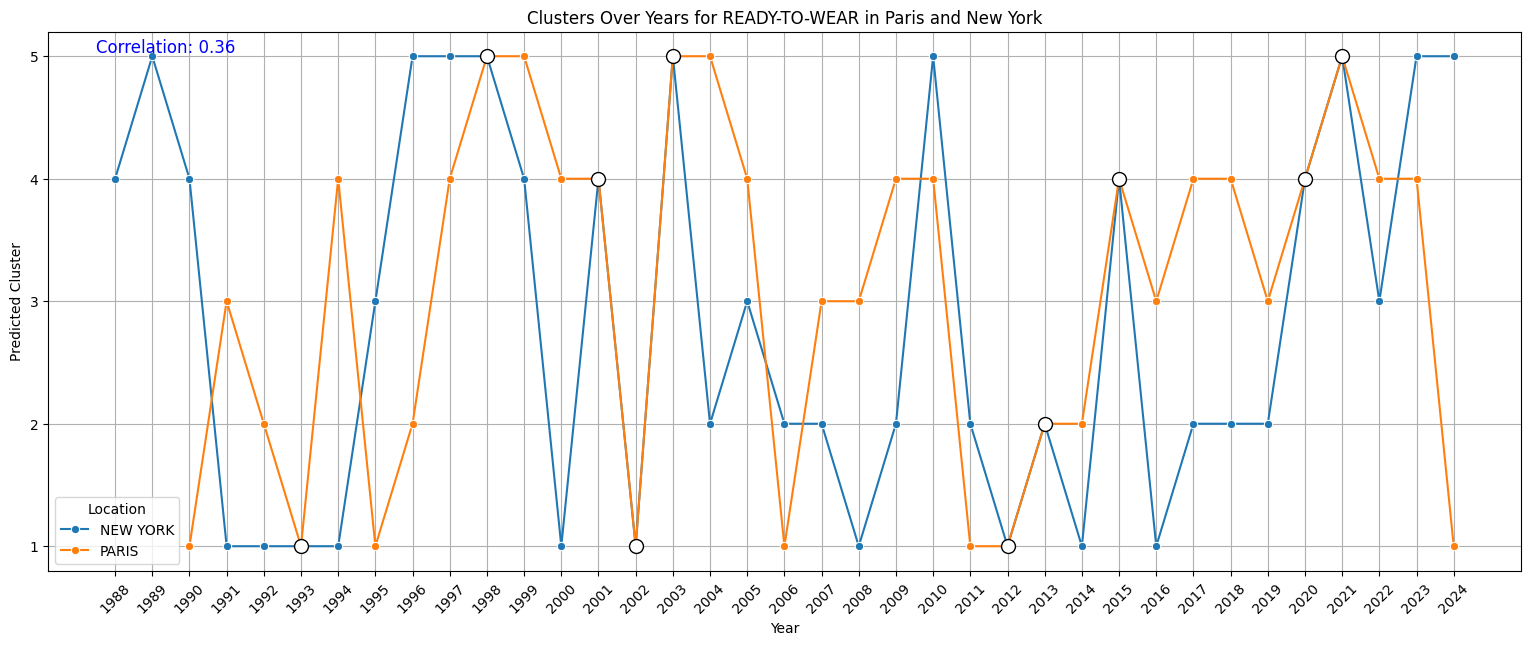

Number of crossovers for MENSWEAR: 12


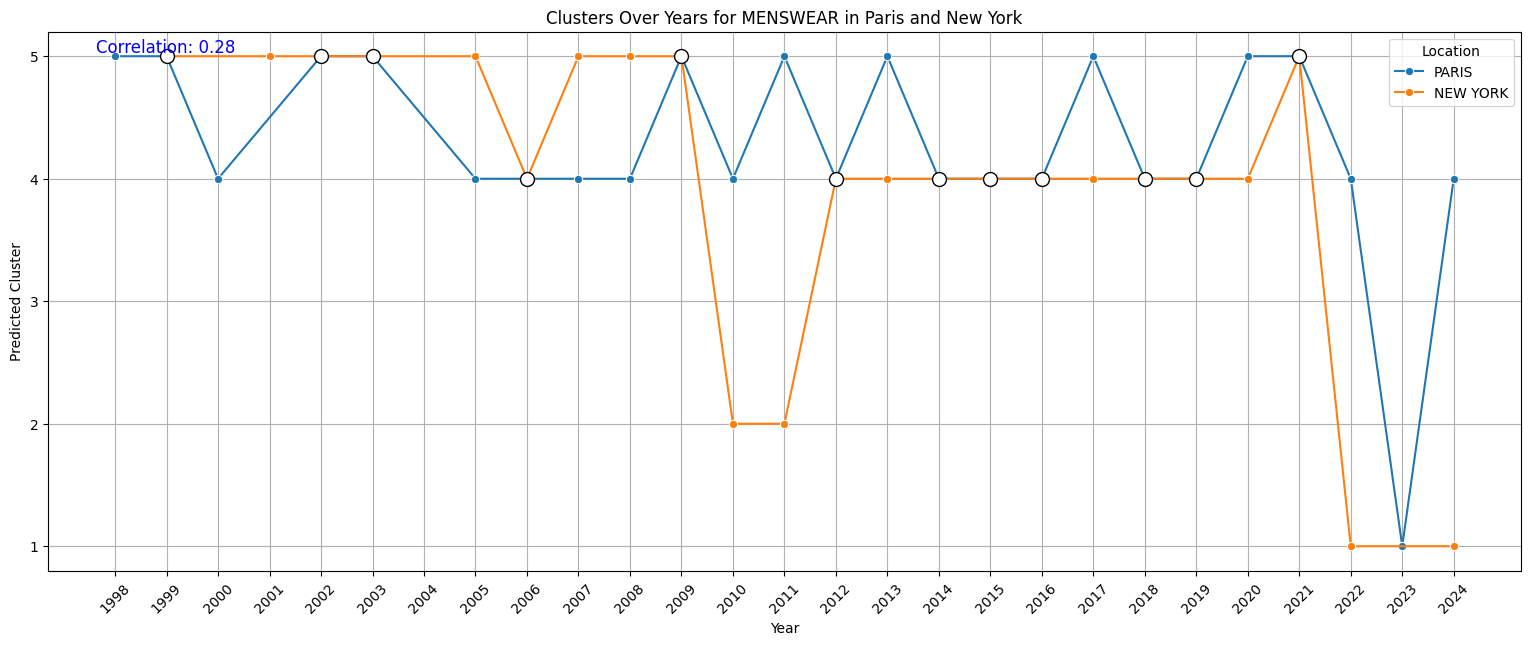

Number of crossovers for COUTURE: 15


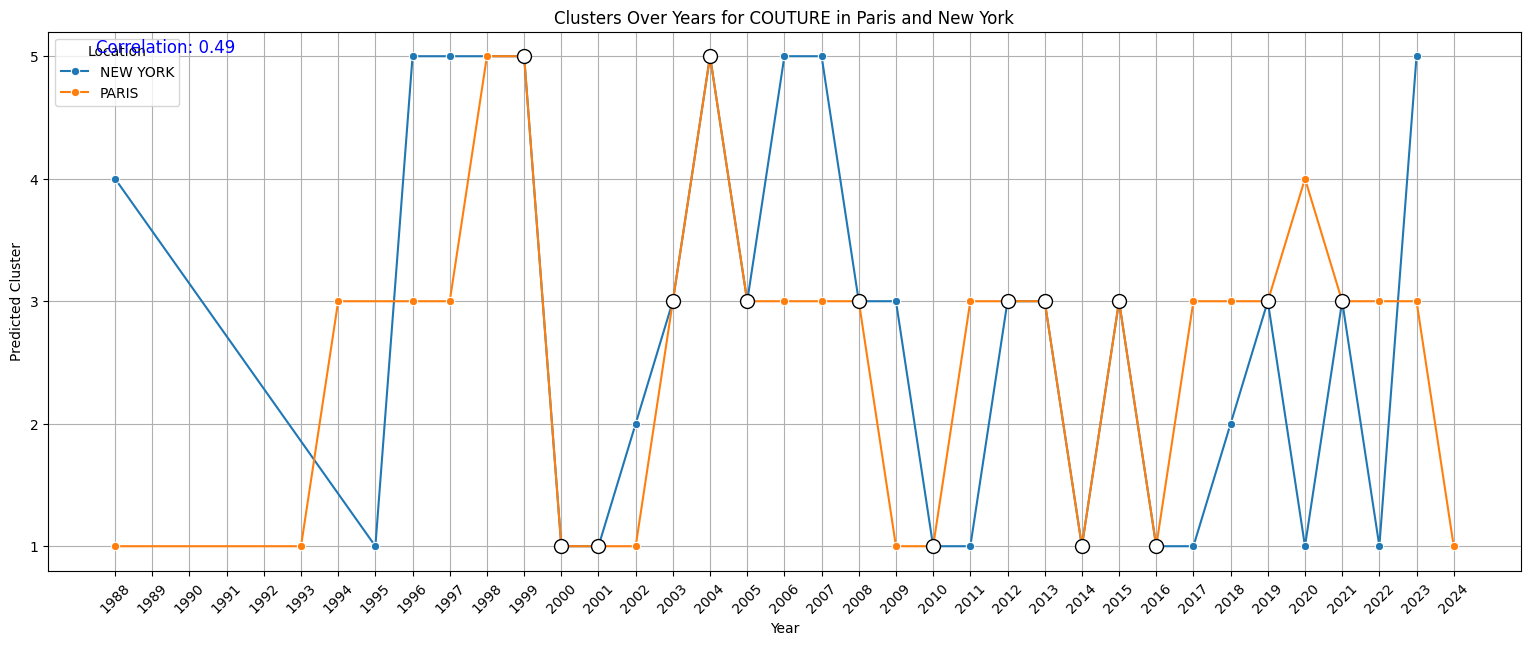

Cluster 1.0 closest point index: 98
Characteristics:
  Colour: blue, pink, white, black, yellow
  Patterns: tassels, ruffles
  Shoes: pointed pumps, pointed boots
  Accessories: headgear, chunky diamond jewelry
  Fabric: mesh, polyester, denim
  Theme: flashy, funk

Cluster 2.0 closest point index: 99
Characteristics:
  Colour: grey, blue
  Patterns: houndstooth
  Shoes: boots
  Accessories: belts
  Fabric: tweed, woollen
  Theme: classic, rich

Cluster 3.0 closest point index: 154
Characteristics:
  Colour: black, blue, yellow, green, red
  Patterns: abstract, ruffles, floral
  Shoes: flats
  Accessories: bags
  Fabric: organza, mesh, cotton, polyester
  Theme: pop

Cluster 4.0 closest point index: 66
Characteristics:
  Colour: white, beige, black, yellow, green
  Patterns: vertical stripes, plain
  Shoes: loafers
  Accessories: bags, hats
  Fabric: linen, polyester
  Theme: classic, academia

Cluster 5.0 closest point index: 29
Characteristics:
  Colour: black, white, grey
  Patterns

/var/folders/4x/1sd2g1vj4bj9nhxxr4xj3v1r0000gn/T/ipykernel_5254/636073811.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


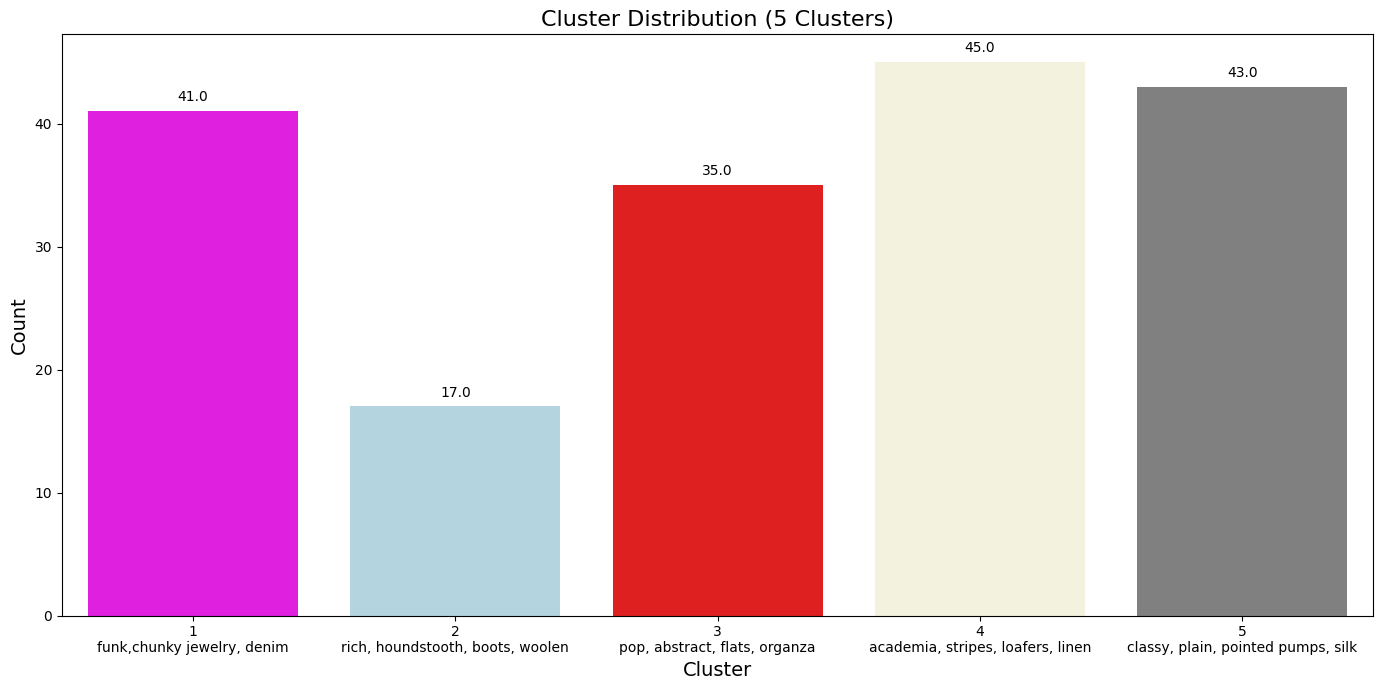

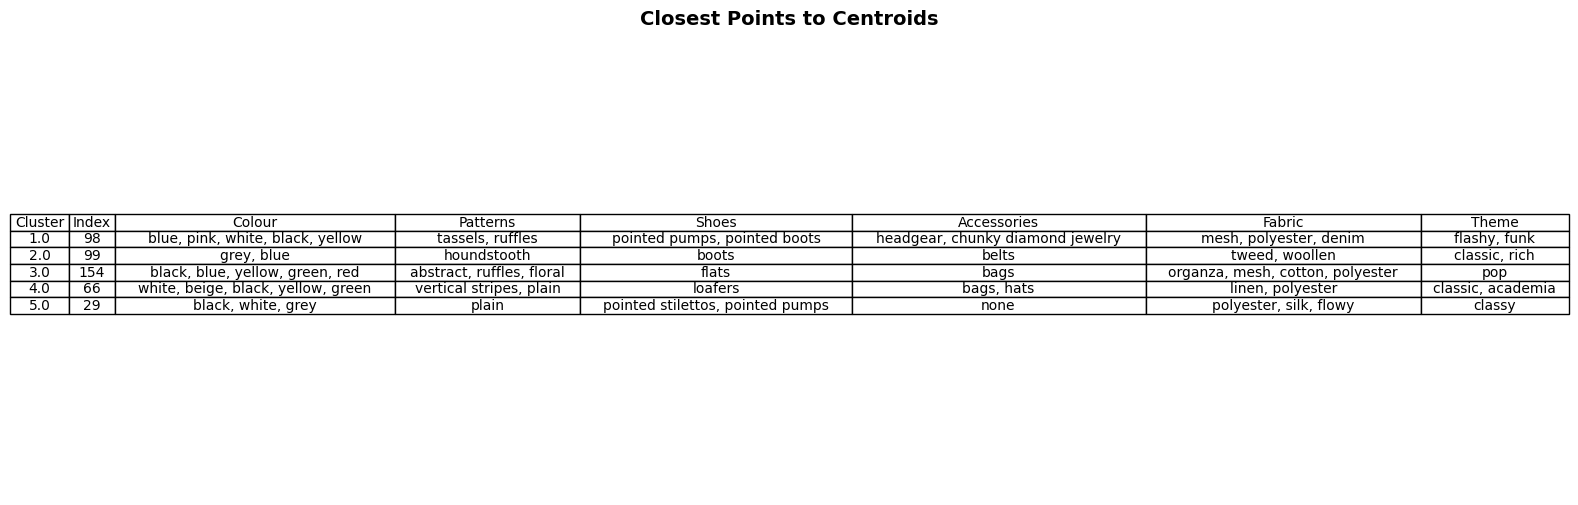

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform


file_path = 'Fashion Dataset - Sheet1.csv'  
data = pd.read_csv(file_path)
data = data[data['Location'].isin(['NEW YORK', 'PARIS'])]

# Preprocessing 
categorical_features = ['Colour', 'Patterns', 'Shoes', 'Accessories', 'Fabric', 'Theme']
columns_to_exclude = ['Year', 'Collection', 'Location', 'Gender', 'Collection Type']
data_for_clustering = data.drop(columns=columns_to_exclude, errors='ignore')

# Encode categorical features and apply weights
mlb = MultiLabelBinarizer()
feature_weights = {
    'Colour': 80,
    'Patterns': 80,
    'Shoes': 80,
    'Accessories': 80,
    'Fabric': 80,
    'Theme': 80
    
}

weighted_data = pd.DataFrame()
for column in categorical_features:
    if column in data_for_clustering:
        encoded_features = mlb.fit_transform(data[column])
        feature_names = mlb.classes_
        weighted_features = encoded_features * feature_weights[column]
        weighted_df = pd.DataFrame(weighted_features, columns=feature_names)
        weighted_data = pd.concat([weighted_data, weighted_df], axis=1)

weighted_data.fillna(0, inplace=True)

# Perform clustering using the weighted data
Z = linkage(weighted_data, method='ward')
num_clusters = 5
clusters = fcluster(Z, num_clusters, criterion='maxclust')
data['PredictedCluster'] = clusters


# Visualizations
plt.figure(figsize=(12, 5))
dendrogram(Z)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.ylim(650,1200)
plt.axhline(y=Z[-(num_clusters - 1), 2], color='r', linestyle='--')  # The cut for 5 clusters
plt.savefig('dendogram2.png', dpi=300)
plt.show()

data['Location'] = data['Location'].str.upper().str.strip()
data['Year'] = pd.to_numeric(data['Year'], errors='coerce')
data_filtered = data[data['Location'].isin(['PARIS', 'NEW YORK'])].copy()
data_filtered.dropna(subset=['Year', 'PredictedCluster'], inplace=True)

collection_types = ['READY-TO-WEAR', 'MENSWEAR', 'COUTURE']

for collection_type in collection_types:
    plt.figure(figsize=(19, 7))
    filtered_data = data_filtered[(data_filtered['Collection Type'].str.upper() == collection_type)]
    if not filtered_data.empty:
        sns.lineplot(data=filtered_data, x='Year', y='PredictedCluster', hue='Location', marker='o',
                     style='Location', dashes=False, errorbar=None)
        plt.title(f'Clusters Over Years for {collection_type} in Paris and New York')
        plt.xlabel('Year')
        plt.ylabel('Predicted Cluster')
        plt.xticks(np.arange(filtered_data['Year'].min(), filtered_data['Year'].max() + 1, 1), rotation=45)
        plt.yticks(np.arange(1, 6, 1))
        plt.grid(True)
        plt.legend(title='Location')

        # Calculate crossovers and correlation
        paris_data = filtered_data[filtered_data['Location'] == 'PARIS']
        new_york_data = filtered_data[filtered_data['Location'] == 'NEW YORK']
        common_years = paris_data['Year'].unique()
        common_years = np.intersect1d(common_years, new_york_data['Year'].unique())

        paris_data = paris_data[paris_data['Year'].isin(common_years)]
        new_york_data = new_york_data[new_york_data['Year'].isin(common_years)]

        crossover_points = []
        for year in common_years:
            paris_cluster = paris_data[paris_data['Year'] == year]['PredictedCluster'].values
            new_york_cluster = new_york_data[new_york_data['Year'] == year]['PredictedCluster'].values
            if len(paris_cluster) > 0 and len(new_york_cluster) > 0:
                if paris_cluster[0] == new_york_cluster[0]:
                    crossover_points.append((year, paris_cluster[0]))

        for year, cluster in crossover_points:
            plt.scatter(year, cluster, color='white', edgecolor='black', s=100, zorder=5, label='Crossover Point' if (year, cluster) == crossover_points[0] else "")

        print(f"Number of crossovers for {collection_type}: {len(crossover_points)}")

        # Correlation
        if len(paris_data['PredictedCluster']) > 0 and len(new_york_data['PredictedCluster']) > 0:
            correlation = np.corrcoef(paris_data['PredictedCluster'], new_york_data['PredictedCluster'])[0, 1]
            plt.figtext(0.15, 0.85, f'Correlation: {correlation:.2f}', fontsize=12, color='blue')
        
        plt.savefig(f'{collection_type.lower().replace(" ", "_")}_clusters_over_years.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print(f"No data available for {collection_type} in Paris and New York.")

data = pd.concat([data, weighted_data], axis=1)

# The centroid and closest point for each cluster
closest_points = {}


for cluster in sorted(data['PredictedCluster'].unique()):
    cluster_data = data[data['PredictedCluster'] == cluster]
    cluster_weighted_data = cluster_data[weighted_data.columns] 
    if not cluster_weighted_data.empty:  
        centroid = cluster_weighted_data.mean().values 

    
        distances = cluster_weighted_data.apply(lambda row: np.linalg.norm(row - centroid), axis=1)
        distances.fillna(np.inf, inplace=True) 
        closest_point_index = distances.idxmin()  
        closest_point = data.loc[closest_point_index]

        closest_points[cluster] = {
            'index': closest_point_index,
            'characteristics': closest_point.to_dict()
        }

for cluster, info in closest_points.items():
    print(f"Cluster {cluster} closest point index: {info['index']}")
    print("Characteristics:")
    keys_to_print = ['Colour', 'Patterns', 'Shoes', 'Accessories', 'Fabric', 'Theme']
    for key in keys_to_print:
        if key in info['characteristics']:
            print(f"  {key}: {info['characteristics'][key]}")
    print()

cluster_colors = ['magenta', 'lightblue', 'red', 'beige', 'gray']

cluster_descriptions = {
    1: "funk,chunky jewelry, denim",
    2: "rich, houndstooth, boots, woolen",
    3: "pop, abstract, flats, organza",
    4: "academia, stripes, loafers, linen",
    5: "classy, plain, pointed pumps, silk"
}

plt.figure(figsize=(14, 7))
ax = sns.countplot(
    x='PredictedCluster', 
    data=data_filtered, 
    order=range(1, num_clusters + 1), 
    palette=cluster_colors
)
plt.title('Cluster Distribution (5 Clusters)', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Count', fontsize=14)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height}", (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

x_labels = [
    f"{cluster}\n{cluster_descriptions[cluster]}" 
    for cluster in range(1, num_clusters + 1)
]
ax.set_xticks(range(len(x_labels)))  # Set the tick positions
ax.set_xticklabels(x_labels, fontsize=10, wrap=True)  

plt.tight_layout()

plt.show()


# Display of Closest Points
import matplotlib.pyplot as plt
import pandas as pd


closest_points_df = pd.DataFrame([
    {
        'Cluster': cluster,
        'Index': info['index'],
        **{key: info['characteristics'].get(key, None) for key in ['Colour', 'Patterns', 'Shoes', 'Accessories', 'Fabric', 'Theme']}
    }
    for cluster, info in closest_points.items()
])

def display_closest_points_table(closest_points_df):
    fig, ax = plt.subplots(figsize=(12, 6)) 
    ax.axis('tight')
    ax.axis('off')
    
    # Table
    table = ax.table(
        cellText=closest_points_df.values,
        colLabels=closest_points_df.columns,
        loc='center',
        cellLoc='center',
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(closest_points_df.columns) + 1)))
    plt.title("Closest Points to Centroids", fontsize=14, weight='bold')
    plt.show()


display_closest_points_table(closest_points_df)




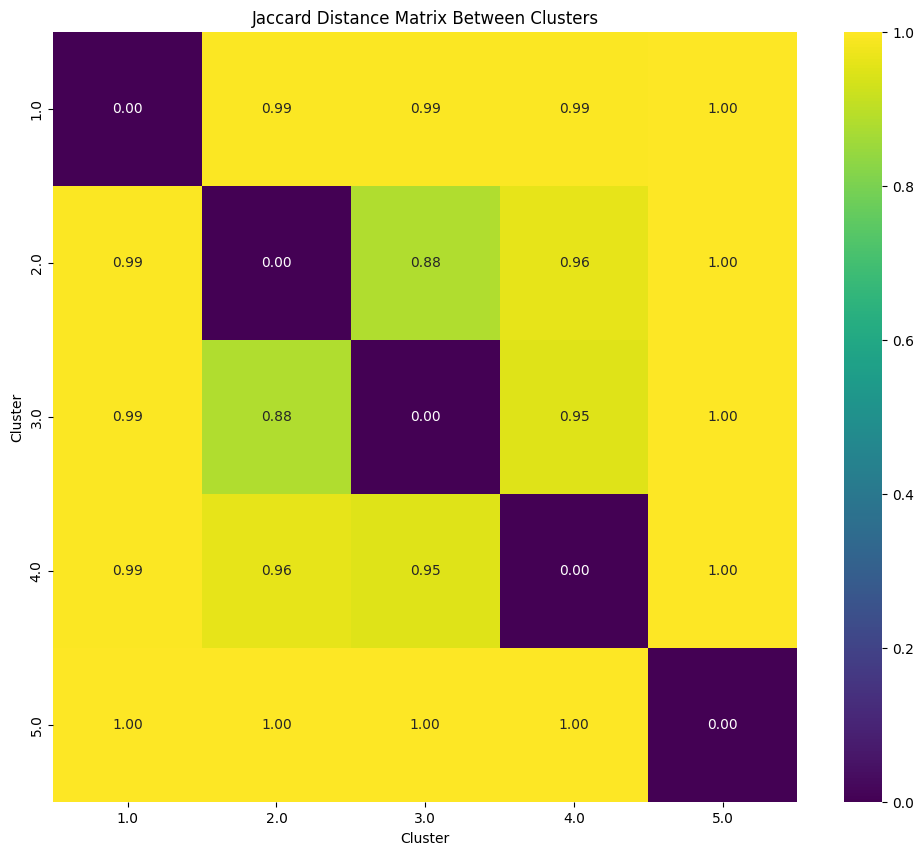

In [5]:
from scipy.spatial.distance import pdist, squareform, jaccard

# Calculate the pairwise distances between cluster centroids using Jaccard distance
numeric_columns = weighted_data.columns  # Ensure only numeric columns are selected
cluster_centroids = data.groupby('PredictedCluster')[numeric_columns].mean()

# Compute the Jaccard distance matrix
distance_matrix_jaccard = pd.DataFrame(
    squareform(pdist(cluster_centroids, metric='jaccard')), 
    index=cluster_centroids.index, 
    columns=cluster_centroids.index
)

# Visualizing the Jaccard Distance Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(distance_matrix_jaccard, annot=True, cmap='viridis', fmt=".2f")
plt.title('Jaccard Distance Matrix Between Clusters')
plt.xlabel('Cluster')
plt.ylabel('Cluster')
plt.savefig('jaccard_distance_matrix.png', dpi=300)
plt.show()
